# DonorsChoose

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

- How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
- How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
- How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [258]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import re

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

from collections import Counter

## 1.1 Reading the data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("The number of datapoints in train data is: ",project_data.shape)
print("*"*100)
print("The name of attributes is: ",project_data.columns.values)

The number of datapoints in train data is:  (109248, 17)
****************************************************************************************************
The name of attributes is:  ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   
2                    Health & Sports    Health & Wellness, Team Sports   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0

In [5]:
print("The number of datapoints in resources is: ",resource_data.shape)
print("*"*100)
print("The name of attributes is: ",resource_data.columns.values)

The number of datapoints in resources is:  (1541272, 4)
****************************************************************************************************
The name of attributes is:  ['id' 'description' 'quantity' 'price']


In [6]:
resource_data.head(5)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

## 1.2 Data Analysis

### Calculating the percentage of projects approved and not approved.

In [7]:
project_value_counts = project_data['project_is_approved'].value_counts()

In [8]:
percent_approved = project_value_counts[1]/(project_value_counts[1]+project_value_counts[0])*100
percent_not_approved = project_value_counts[0]/(project_value_counts[1]+project_value_counts[0])*100

In [9]:
print("The number of projects approved for funding is {} which is {} % of the total projects"
.format(project_value_counts[1],percent_approved))

print("And the number of non approved projects is {} which is {} % of the total projects"
.format(project_value_counts[0],percent_not_approved))

The number of projects approved for funding is 92706 which is 84.85830404217927 % of the total projects
And the number of non approved projects is 16542 which is 15.141695957820739 % of the total projects


- From the above it is clear that approx 85% of the projects gets approved and the remaining 15% doesnt get approved 
- Now lets plot a donaught plot to vizualize these percentage values.

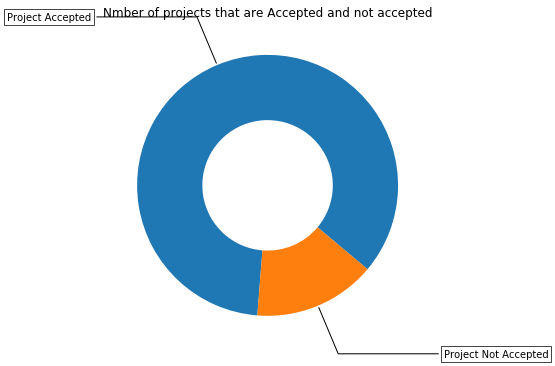

In [10]:
## PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
## https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
## The below code will plot a donut plot which will help us to visualize thr total projects.

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Project Accepted", "Project Not Accepted"]

data = [project_value_counts[1], project_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

## 1.2.1 Univariate Analysis : School State

In [11]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean).reset_index())
temp.head(5)

school_state  project_is_approved
0           AK             0.840580
1           AL             0.854711
2           AR             0.831268
3           AZ             0.838379
4           CA             0.858136

In [12]:
temp.columns = ["state_code","num_proposals"]
temp.head(5)

state_code  num_proposals
0         AK       0.840580
1         AL       0.854711
2         AR       0.831268
3         AZ       0.838379
4         CA       0.858136

#### Plotting the Heat map of US State

In [13]:
#How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [14]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf

temp.sort_values(['num_proposals'],inplace = True)
print("The State with Lowest % Approvals")
print(temp.head())
print("="*80)
print("The with Highest % Approvals")
print(temp.tail())

The State with Lowest % Approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
The with Highest % Approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


## Summary :
#### 1.Delaware(DE) state has the highest percentage of projects accepted having almost 90% acceptance rate, followed by North Dakota(ND) and Washington(WA) nearly 89% and 88% respectively.
#### 2. Vermont(VT) has the lowest acceptance rate followed by District of Columbia(DC) and Texas(TX) with nearly 80% and 81% respectively.

In [15]:
# stacked bar plots matplotlib
# https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

def stack_plot(data, xtick, col2 = 'project_is_approved', col3 = 'total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects',fontsize = 15)
    plt.title('Number of projects aproved vs rejected', fontsize = 15)
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show() 

In [16]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*80)
    print(temp.tail(5))

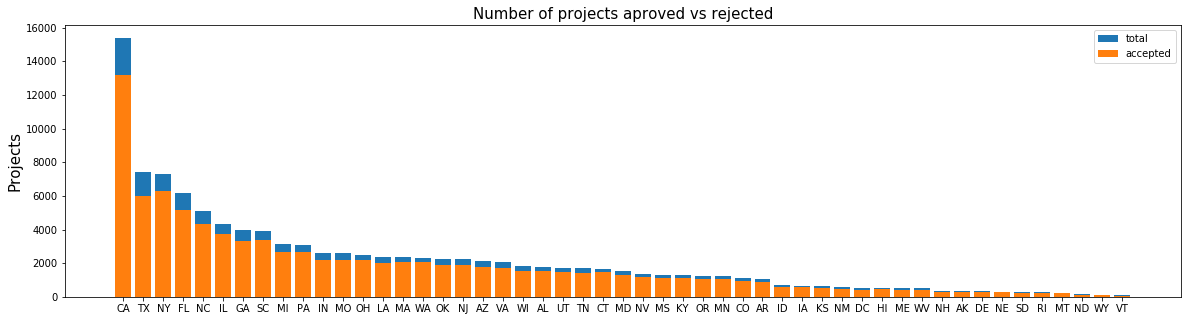

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [17]:
univariate_barplots(project_data,'school_state','project_is_approved', top = False)

## Summary:

#### 1. Every state has greater than 80% success rate in approval.
#### 2. We can see variedness in the number of projects submitted between the states.
#### 3. A Total of 15388 number of projects submitted alone by California which is the highest among all the states and the success rate is 85% ie 13205 out of 15388.
#### 4. It can also be noticed that the state with minimum number of projects applied is Vermont(VT) i.e 80, exactly 80% of the projects got approved(64). Only 16 projects failed to get approved.

## 1.2.2 Univariate Analysis: teacher_prefix

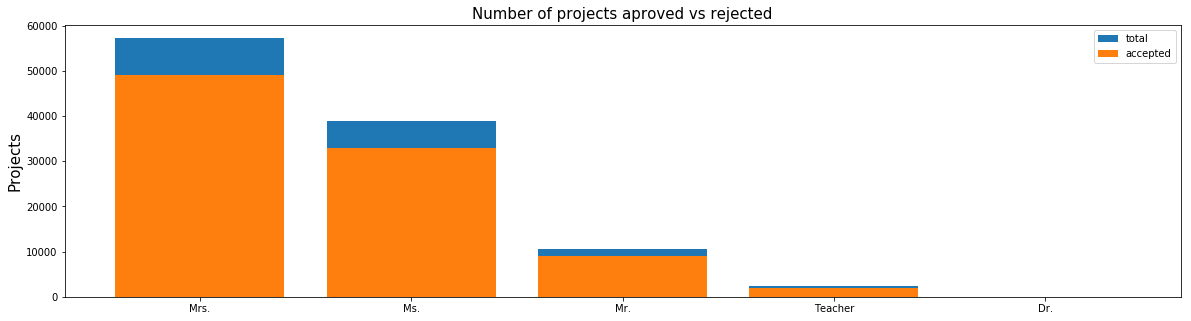

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [18]:
univariate_barplots(project_data,'teacher_prefix','project_is_approved', top = False)

## Summary: 

#### 1. There is a huge gap between the total projects submitted between males and females, female teachers have applied a lot more projects than male teachers.
#### 2. Teachers with Prefix Mrs. means married woman teachers have applied the most of projects and the acceptance rate is well above 85% followed by non married female teachers whose acceptance rate is 84%.
#### 3. Mr. prefix teachers i.e males have only applied 10648, which is very less as compared to female teachers.
#### 4. Dr. Prefix teachers have proposed only 13 projects which is the lowest, and out of those 9 proposals got accepted.

## 1.2.3 Univariate Analysis : project_grade_category

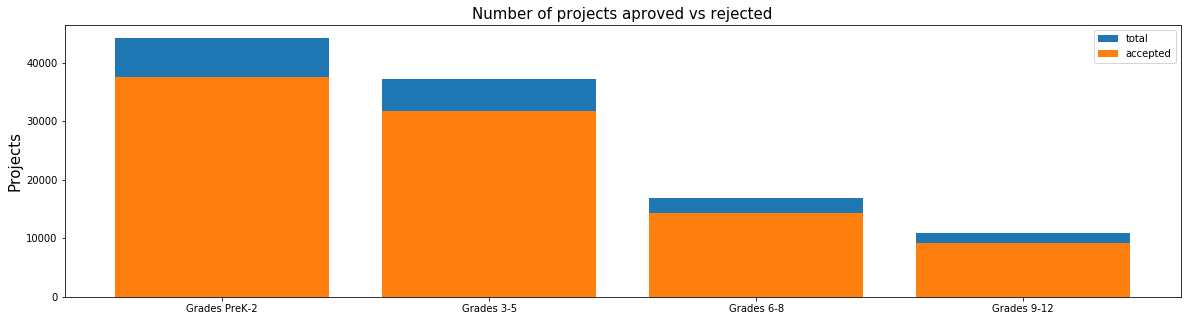

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [19]:
univariate_barplots(project_data,'project_grade_category','project_is_approved',top = False)

## Summary:

#### 1. Maximum number of Projects have been approved for the students between the grades PreK & 2 and nearly 85% is the acceptance rate.
#### 2. For almost all the grades the average project acceptance rate is 84%.
#### 3. It can also be noticed that for the higher garde students i.e grades 6-8 & grades 9-12, the number of projects is less as compared to the rest grades.

## Univariate Analysis: project_subject_categories

In [20]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [21]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

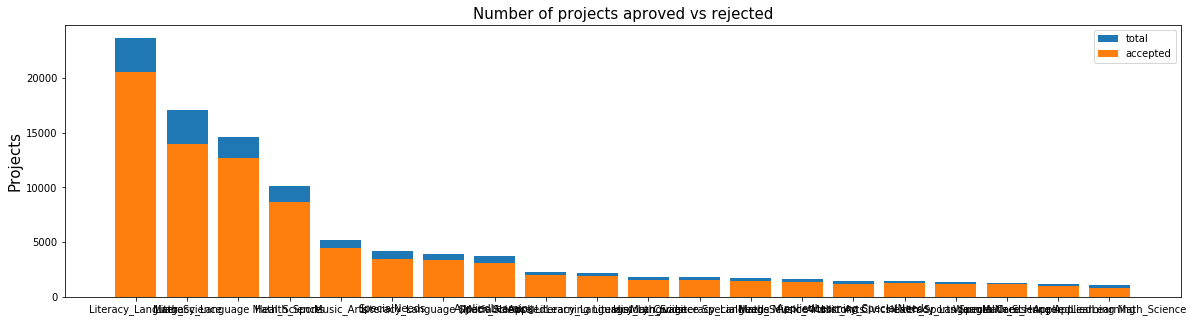

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [22]:
univariate_barplots(project_data,'clean_categories','project_is_approved',top = 20)

## Summary:

#### 1. Variability is found in total project proposals per subject categories.
#### 2. Maximum number of projects propposed is for the category Literacy_Language having the acceptance rate of approx 87% followed by Math_Science with 82% acceptance rate.
#### 3. When the category Literacy_Language is combined with Math_Science the acceptance rate increases to 87%.
#### 4. Those projects which came under the Warmth Care_Hunger has the most acceptance rate of 92% i.e out of 1309 projects submitted 1212 projects got cleared.
#### 5. Combining Math and Science with the AppliedLearnig decreases the acceptance rate.

In [23]:
# Plotting % of projects approved category wise.
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039

my_counter = Counter()    # initializing object to Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

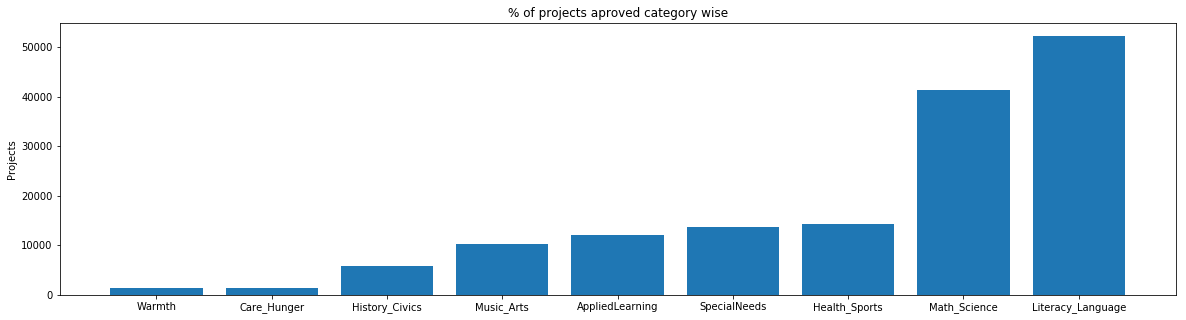

In [24]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [25]:
for i,j in sorted_cat_dict.items():
    print('{:20} : {:10}'.format(i,j))

Warmth               :       1388
Care_Hunger          :       1388
History_Civics       :       5914
Music_Arts           :      10293
AppliedLearning      :      12135
SpecialNeeds         :      13642
Health_Sports        :      14223
Math_Science         :      41421
Literacy_Language    :      52239


## Summary: Indivisual Categories for each project

#### 1. Literacy_Language is the category in which the highest number of projects are enrolled with 52239 projects followed by Maths_Science with 41421 total enrolled.
#### 2. A total of 1388 projects proposed under the categories Warmth and Care_Hunger

## 1.2.5 Univariate Analysis: project_subject_subcategories

In [26]:
# Removing Special characters as done in project_subject_subcategories
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_catogories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []

for i in sub_catogories:
    temp = ""
    for j in i.split(','):
        
        if 'The' in j.split():
            j = j.replace('The','')
        j = j.replace(' ','')
        temp = temp + j.strip()+ " "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [27]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis = 1, inplace = True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

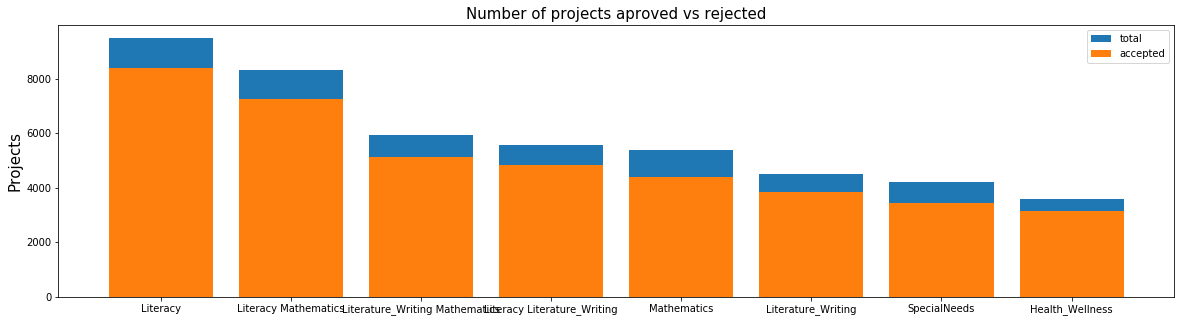

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
             clean_subcategories  project_is_approved  total       Avg
318  Literacy Literature_Writing                 4823   5571  0.865733
342                  Mathematics                 4385   5379  0.815207
330           Literature_Writing                 3846   4501  0.854477
392                 SpecialNeeds                 3431   4226  0.811879
289              Health_Wellness                 3131   3583  0.873849


In [28]:
univariate_barplots(project_data,'clean_subcategories','project_is_approved', top = 8)

## Summary:

#### 1. The Subcategory Literacy has the most number of projects proposed i.e 9486, out of total 8371 got approved making the accepatnce rate to 86%.
#### 2. Likewise the Subcategory Health_wellness has the least number of projects proposed i.e 3583, and out of total 3131 got approved making the acceptance rate to 87%

In [29]:
# Plotting % of projects approved category wise.
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039

my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

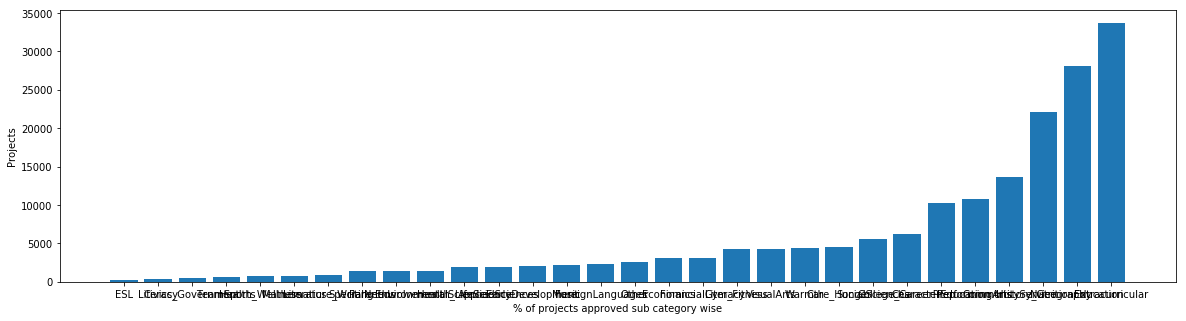

In [30]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039

sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key = lambda kv: kv[1]))

ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))
plt.ylabel('Projects')
plt.xlabel('% of projects approved sub category wise')
plt.xticks(ind, list(sub_cat_dict.keys()))
plt.show()

In [31]:
for i,j in sorted_sub_cat_dict.items():
    print("{:20}:{:10}".format(i,j))

Economics           :       269
CommunityService    :       441
FinancialLiteracy   :       568
ParentInvolvement   :       677
Extracurricular     :       810
Civics_Government   :       815
ForeignLanguages    :       890
NutritionEducation  :      1355
Warmth              :      1388
Care_Hunger         :      1388
SocialSciences      :      1920
PerformingArts      :      1961
CharacterEducation  :      2065
TeamSports          :      2192
Other               :      2372
College_CareerPrep  :      2568
Music               :      3145
History_Geography   :      3171
Health_LifeScience  :      4235
EarlyDevelopment    :      4254
ESL                 :      4367
Gym_Fitness         :      4509
EnvironmentalScience:      5591
VisualArts          :      6278
Health_Wellness     :     10234
AppliedSciences     :     10816
SpecialNeeds        :     13642
Literature_Writing  :     22179
Mathematics         :     28074
Literacy            :     33700


## Summary:

#### 1. The Literacy Subcategory has the highest number of projects proposed i.e 33700.
#### 2. Similarily Subcategory Economics has the lowest number of projects enrolled i.e 269

## Text Features

## 1.2.6 Univariate Analysis: project_title (Text features)

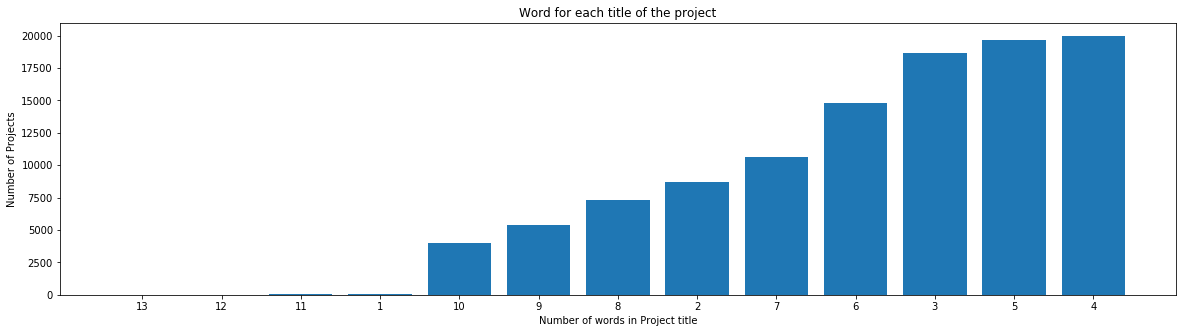

In [32]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
# Bar plot according word count of project_title

word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)       # dictionary conversion

word_dict = dict(sorted(word_count.items(), key = lambda kv: kv[1]))    # Sorting

# plotting code
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Projects')
plt.xlabel('Number of words in Project title')
plt.title('Word for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [33]:
for i,j in word_dict.items():
    print("{:5}:{:8}".format(i,j))

   13:       1
   12:      11
   11:      30
    1:      31
   10:    3968
    9:    5383
    8:    7289
    2:    8733
    7:   10631
    6:   14824
    3:   18691
    5:   19677
    4:   19979


## Summary:

#### 1. Most of the projects have a length of 4 words in its title
#### 2. Maximum projects have a title length of 3,4,and 5.
#### 3. Very less number of projects have title more than 10 words.
#### 4. Only One project has the title of 13 words.

#### Lets calculate the word count of projects approved and rejected

In [34]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

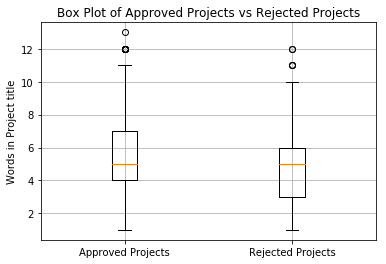

In [35]:
# Plotting Box plot
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html

plt.boxplot([approved_title_word_count,rejected_title_word_count])
plt.xticks([1,2],('Approved Projects', 'Rejected Projects'))
plt.ylabel("Words in Project title")
plt.title('Box Plot of Approved Projects vs Rejected Projects')
plt.grid()
plt.show()

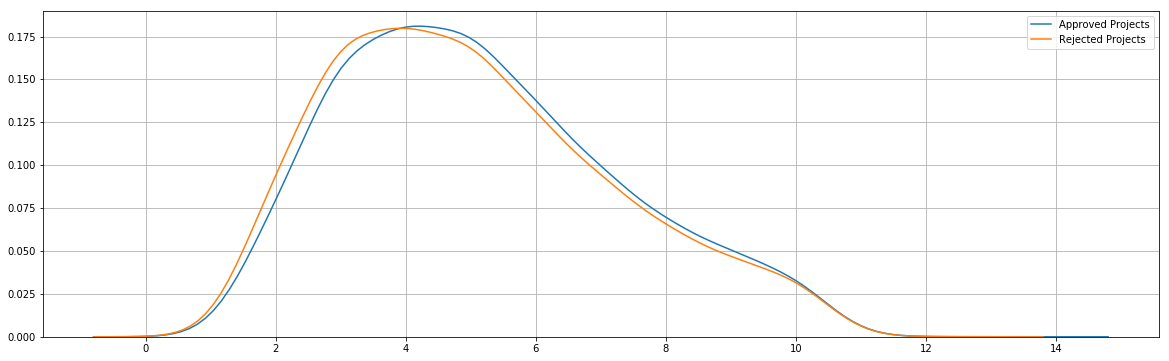

In [36]:
# Plotting Kdeplot
plt.figure(figsize=(20,6))
sns.kdeplot(approved_title_word_count, label = 'Approved Projects', bw = 0.6)
sns.kdeplot(rejected_title_word_count, label = 'Rejected Projects', bw = 0.6)
plt.legend()
plt.grid()
plt.show()

## Summary:

#### 1. It can be shown from the plot that the number of projects approved have slightly more number of words in title compared to  the rejected projects.

## 1.2.7 Univariate Analysis: project_essays (Text Featutres)

In [37]:
# Merging project_essays columns of the dataframe
project_data['essay'] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) +\
                        project_data["project_essay_3"].map(str) +\
                        project_data["project_essay_4"].map(str)

In [38]:
# Counting the number of words in project_essay for approved and rejected projects.

approved_essay_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_essay_word_count = approved_essay_word_count.values


rejected_essay_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_essay_word_count = rejected_essay_word_count.values

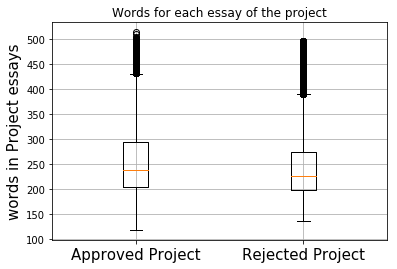

In [39]:
# Plotting Box plot
plt.boxplot([approved_essay_word_count,rejected_essay_word_count])
plt.title("Words for each essay of the project")
plt.ylabel("words in Project essays",fontsize = 15)
plt.xticks([1,2],("Approved Project","Rejected Project"),fontsize= 15)
plt.grid()
plt.show()

## Summary: 

#### 1. By seeing the above plot we can notice that the approved projects have slightly more words in their project essay as compared to the number of words of rejected projects.

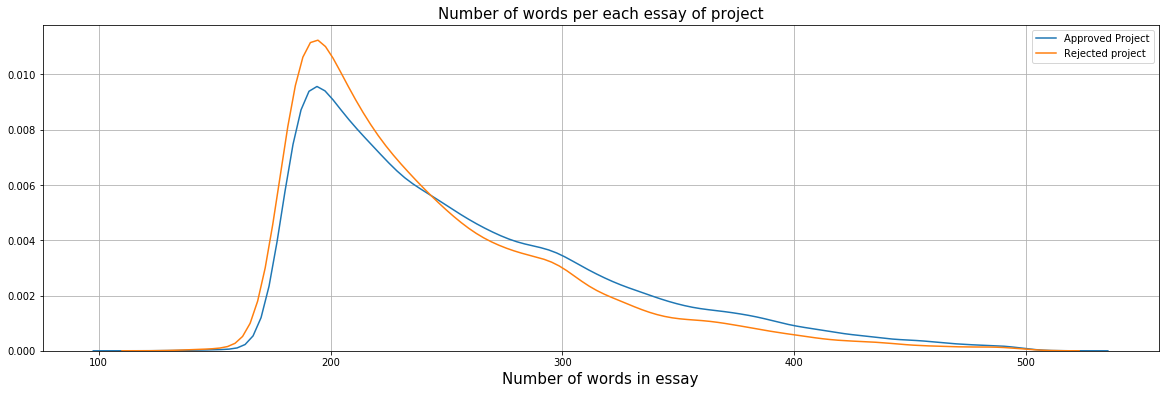

In [40]:
# plotting kde plot
plt.figure(figsize=(20,6))
sns.kdeplot(approved_essay_word_count, label = 'Approved Project')
sns.kdeplot(rejected_essay_word_count, label = 'Rejected project')
plt.title('Number of words per each essay of project',fontsize = 15)
plt.xlabel('Number of words in essay',fontsize = 15)
plt.legend()
plt.grid()
plt.show()

## Summary:

#### 1. We can conclude the same result that we have collected from the Box plot that the number of words in essay in approved projects have slightly more than the number of words in essay in rejected projects. This can be noticed by seeing the pdf line of approved projects, the curve getting denser for more number words.

## Univariate Analysis: 

In [41]:
# We can find the cost of the projects from the resource table.
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [42]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price' : 'sum', 'quantity' : 'sum'}).reset_index()

In [43]:
price_data.head()

id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8

In [44]:
# Joining the two dataframes
project_data = pd.merge(project_data,price_data,on = 'id', how = 'left')
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [45]:
approved_price = project_data[project_data['project_is_approved'] == 1]['price'].values

rejected_price = project_data[project_data['project_is_approved'] == 0]['price'].values

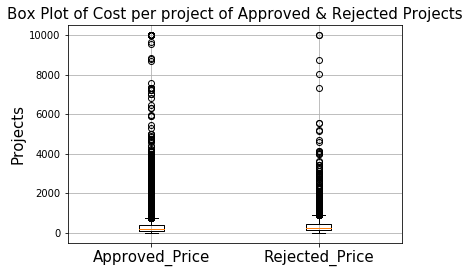

In [46]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
# Box Plot
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plot of Cost per project of Approved & Rejected Projects', fontsize = 15)
plt.ylabel('Projects', fontsize = 15)
plt.xticks([1,2],('Approved_Price','Rejected_Price'), fontsize = 15)
plt.grid()
plt.show()

## Summary:

#### 1. It is very difficult to extract any meaningful information from the above Box Plot.

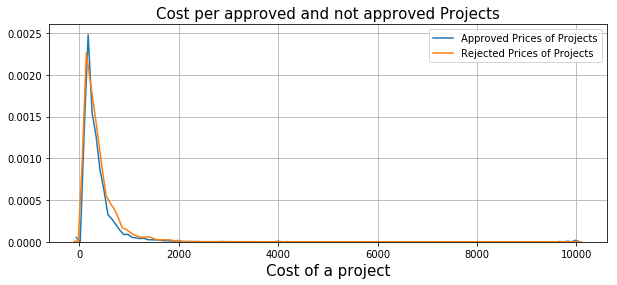

In [47]:
# Plotting kde plot
plt.figure(figsize= (10,4))
sns.distplot(approved_price, hist = False, label = 'Approved Prices of Projects')
sns.distplot(rejected_price, hist = False, label = 'Rejected Prices of Projects')
plt.title('Cost per approved and not approved Projects', fontsize = 15)
plt.xlabel('Cost of a project', fontsize = 15)
plt.legend()
plt.grid()
plt.show()

## Summary:

#### 1. Both the Pdf curves are almost overlapping with each other, nothing much can be predicted from this plot as well.

#### Generating PrettyTable
A table can be created with add_row() or add_column() methods.

In [48]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Percentile","Approved Projects","Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i),3), np.round(np.percentile(rejected_price,i),3)])

print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

## Summary:

#### 1. From the above table we can say all the approved projects have low cost as compared to the rejected projects.
#### 2. None of the approved projects cost is more than the rejected projects.
#### 3. The maximun price of any project to enroll should not be more than 10,000 dollars

## 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects

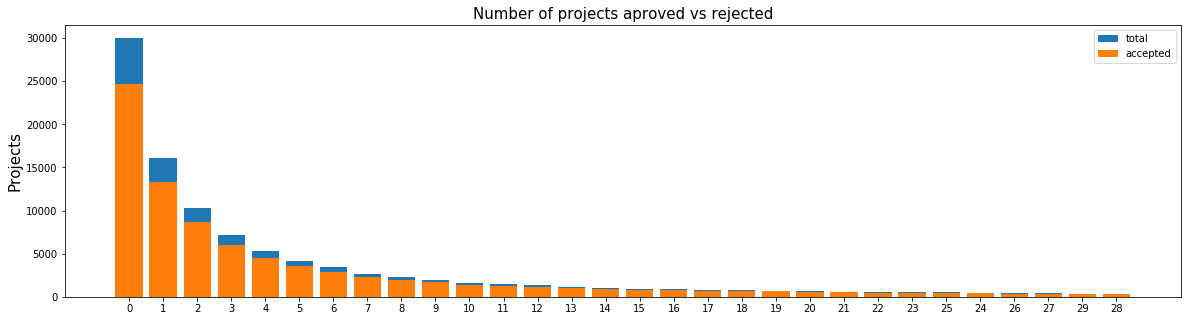

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
24                                            24                  405    449   
26                                            26                  378    445   
27                                            27                  352    394   
29                                            29                  336    370   
28                                       

In [49]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved',top = 30)

## Summary:

#### 1. We can see that maximum number of project are proposed by New teachers and the acceptance rate is 82%.
#### 2. Approval rate increases for those teachers who have posted more than 15 projects.

## 1.2.10 Univariate Analysis: project_resource_summary

In [50]:
# for some step related help// https://github.com/harrismohammed/DonorsChoose.org---Bow-tfidf-avgw2v-tfidfw2v-tsne-EDA
# Separating the data and converting into list from the dataset to work further.

summary = list(project_data['project_resource_summary'])
summary[0:10]

['My students need opportunities to practice beginning reading skills in English at home.',
 'My students need a projector to help with viewing educational programs',
 'My students need shine guards, athletic socks, Soccer Balls, goalie gloves, and training materials for the upcoming Soccer season.',
 'My students need to engage in Reading and Math in a way that will inspire them with these Mini iPads!',
 'My students need hands on practice in mathematics. Having fun and personalized journals and charts will help them be more involved in our daily Math routines.',
 'My students need movement to be successful. Being that I have a variety of students that have all different types of needs, flexible seating would assist not only these students with special needs, but all students.',
 'My students need some dependable laptops for daily classroom use for reading and math.',
 'My students need ipads to help them access a world of online resources that will spark their interest in learning.',

In [51]:
len(summary)

109248

In [52]:
## Check if the presence of the numerical digits in the project_resource_summary.
from tqdm import tqdm
digit_summary = {}

for x in range(len(summary)):
    for s in summary[x].split():
        if s.isdigit():
            digit_summary[x] = int(s)           

In [53]:
digit_summary[16]

2

In [54]:
len(digit_summary)

11237

In [55]:
# We only have the dictionary of the text having nemuric values only but to go futher we need to consider the whole sentence
# sentence of project_resource_summary. For this we can assign '0' to those which doesnt contain any numeric values.

digit_whole = {}        # to store all the numerical digits of project resource summary including zeros.

for a in range(len(summary)):
    if a in digit_summary.keys():
        digit_whole[a] = digit_summary[a]
    else:
        digit_whole[a]= 0        

In [56]:
for i in tqdm(range(20)):
    print(digit_whole[i])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
0
2
0
0
7


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 425.31it/s]


In [57]:
len(digit_whole)

109248

In [58]:
# Converting all the numerical digits into 0 & 1
# lets take an empty list to store the values.

digit_in_summary = []
for i in tqdm(digit_whole.values()):
    if i > 0 :
        digit_in_summary.append(1)
    else:
        digit_in_summary.append(0)

100%|█████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 1679609.56it/s]


In [59]:
digit_in_summary[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

In [60]:
# Adding digit_in_summary to the original dataframe.
project_data['digit_in_summary'] = digit_in_summary

In [61]:
project_data.head(20)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1       140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2        21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3           45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4       172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   
5       141660  p154343  a50a390e8327a95b77b9e495b58b9a6e           Mrs.   
6        21147  p099819  9b40170bfa65e399981717ee8731efc3           Mrs.   
7        94142  p092424  5bfd3d12fae3d2fe88684bbac570c9d2            Ms.   
8       112489  p045029  487448f5226005d08d36bdd75f095b31           Mrs.   
9       158561  p001713  140eeac1885c820ad5592a409a3a8994            Ms.   
10       43184  p040307  363788b51d40d978fe276bcb1f8a2b35           Mrs.   
11      127083  p251806  4ba7c721133ef651ca54a03551746708            Ms.   
12       19090  p051126  5e52c92b7e3c472aad247a239d345543           Mrs.   
13       15126  p003874  178f6ae765cd4e0fb143a77c47fd65e2           Mrs.   
14       62232  p233127  424819801de22a60bba7d0f4354d0258            Ms.   
15       67303  p132832  bb6d6d054824fa01576ab38dfa2be160            Ms.   
16      127215  p174627  4ad7e280fddff889e1355cc9f29c3b89           Mrs.   
17      157771  p152491  e39abda057354c979c5b075cffbe5f88            Ms.   
18      122186  p196421  fcd9b003fc1891383f340a89da02a1a6           Mrs.   
19      146331  p058343  8e07a98deb1bc74c75b97521e05b1691            Ms.   

   school_state project_submitted_datetime project_grade_category  \
0            IN        2016-12-05 13:43:57          Grades PreK-2   
1            FL        2016-10-25 09:22:10             Grades 6-8   
2            AZ        2016-08-31 12:03:56             Grades 6-8   
3            KY        2016-10-06 21:16:17          Grades PreK-2   
4            TX        2016-07-11 01:10:09          Grades PreK-2   
5            FL        2017-04-08 22:40:43             Grades 3-5   
6            CT        2017-02-17 19:58:56             Grades 6-8   
7            GA        2016-09-01 00:02:15             Grades 3-5   
8            SC        2016-09-25 17:00:26          Grades PreK-2   
9            NC        2016-11-17 18:18:56          Grades PreK-2   
10           CA        2017-01-04 16:40:30             Grades 3-5   
11           CA        2016-11-14 22:57:28          Grades PreK-2   
12           NY        2016-05-23 15:46:02             Grades 6-8   
13           OK        2016-10-17 09:49:27          Grades PreK-2   
14           MA        2017-02-14 16:29:10          Grades PreK-2   
15           TX        2016-10-05 21:05:38             Grades 3-5   
16           FL        2017-01-18 10:59:05          Grades PreK-2   
17           NV        2016-11-23 17:14:17             Grades 3-5   
18           GA        2016-08-28 15:04:42          Grades PreK-2   
19           OH        2016-08-06 13:05:20             Grades 3-5   

                                        project_title  \
0    Educational Support for English Learners at Home   
1               Wanted: Projector for Hungry Learners   
2   Soccer Equipment for AWESOME Middle School Stu...   
3                              Techie Kindergarteners   
4                              Interactive Math Tools   
5   Flexible Seating for Mrs. Jarvis' Terrific Thi...   
6   Chromebooks for Special Education Reading Program   
7                               It's the 21st Century   
8                     Targeting More Success in Class   
9     Just For the Love of Reading--\r\nPure Pleasure   
10                              Reading Changes Lives   
11  Elevating Academics and Parent Rapports Throug...   
12                  Building Life Science Experiences   
13                     Everyone deserves to be heard!   
14                      TABLETS CAN SHOW US THE WORLD   
15                               Making Reces

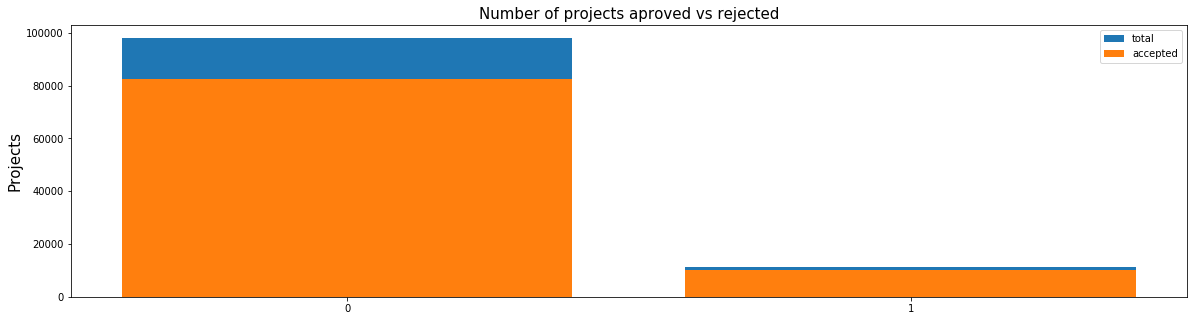

   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723
   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723


In [62]:
univariate_barplots(project_data,'digit_in_summary','project_is_approved')

## Summary:

#### 1. It is clearly depicted from the plot that majority of the projects which are proposed doesnot contain any numeric values, and the rate of acceptance is 84%
#### 2. Though the number of projects containing numirical values, but we can say that the rate of acceptance for those projects is slightly more than 90% 

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [63]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2        ...         \
0  \"The limits of your language are the limits o...        ...          
1  The projector we need for our school is very c...        ...          

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   digit_in_summary  
0                 0  
1                 0  

[2 rows x 21 columns]

In [64]:
# lets print some random essays:

print('='*120)
print(project_data['essay'].values[0])
print('\n')
print('='*120)
print(project_data['essay'].values[150])
print('\n')
print('='*120)
print(project_data['essay'].values[1000])
print('\n')
print('='*120)
print(project_data['essay'].values[20000])
print('\n')
print('='*120)
print(project_data['essay'].values[99999])
print('\n')
print('='*120)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

## Summary: 
#### From the above random text of essay we can observe that the sentences contains special characters, punctuations etc which are of no use to us while performing the preprocessing of text, so we will have to remove those from the sentences.

In [65]:
# https://stackoverflow.com/a/47091490/4084039

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [66]:
sent = decontracted(project_data['essay'].values[1000])
print(sent)
print('='*120)

How do you remember your days of school? Was it in a sterile environment with plain walls, rows of desks, and a teacher in front of the room? A typical day in our room is nothing like that. I work hard to create a warm inviting themed room for my students look forward to coming to each day.\r\n\r\nMy class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas.\r\nThey attend a Title I school, which means there is a high enough percentage of free and reduced-price lunch to qualify. Our school is an \"open classroom\" concept, which is very unique as there are no walls separating the classrooms. These 9 and 10 year-old students are very eager learners; they are like sponges, absorbing all the information and experiences and keep on wanting more.With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets, I will be able to help create the mood in our classroom setting to be one of a themed nautical enviro

In [67]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/

sent = sent.replace('\\r',' ')
sent = sent.replace('\\"',' ')
sent = sent.replace('\\n',' ')
print(sent)

How do you remember your days of school? Was it in a sterile environment with plain walls, rows of desks, and a teacher in front of the room? A typical day in our room is nothing like that. I work hard to create a warm inviting themed room for my students look forward to coming to each day.    My class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas.  They attend a Title I school, which means there is a high enough percentage of free and reduced-price lunch to qualify. Our school is an  open classroom  concept, which is very unique as there are no walls separating the classrooms. These 9 and 10 year-old students are very eager learners; they are like sponges, absorbing all the information and experiences and keep on wanting more.With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets, I will be able to help create the mood in our classroom setting to be one of a themed nautical environment. C

In [68]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039

sent = re.sub('[^A-Za-z0-9]+',' ',sent)
print(sent)

How do you remember your days of school Was it in a sterile environment with plain walls rows of desks and a teacher in front of the room A typical day in our room is nothing like that I work hard to create a warm inviting themed room for my students look forward to coming to each day My class is made up of 28 wonderfully unique boys and girls of mixed races in Arkansas They attend a Title I school which means there is a high enough percentage of free and reduced price lunch to qualify Our school is an open classroom concept which is very unique as there are no walls separating the classrooms These 9 and 10 year old students are very eager learners they are like sponges absorbing all the information and experiences and keep on wanting more With these resources such as the comfy red throw pillows and the whimsical nautical hanging decor and the blue fish nets I will be able to help create the mood in our classroom setting to be one of a themed nautical environment Creating a classroom e

In [69]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')   # To remove words that comes under the stopword.
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [70]:
# Combining all the above statements.

from tqdm import tqdm
preprocessed_essays = []

for sentence in tqdm(project_data['essay'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r',' ')
    sent = sent.replace('\\"',' ')
    sent = sent.replace('\\n',' ')
    sent = re.sub('[^A-Za-z0-9]+',' ',sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [01:50<00:00, 988.36it/s]


In [71]:
# After preprocessing
preprocessed_essays[1000]

'how remember days school was sterile environment plain walls rows desks teacher front room a typical day room nothing like i work hard create warm inviting themed room students look forward coming day my class made 28 wonderfully unique boys girls mixed races arkansas they attend title i school means high enough percentage free reduced price lunch qualify our school open classroom concept unique walls separating classrooms these 9 10 year old students eager learners like sponges absorbing information experiences keep wanting with resources comfy red throw pillows whimsical nautical hanging decor blue fish nets i able help create mood classroom setting one themed nautical environment creating classroom environment important success every child education the nautical photo props used child step foot classroom first time meet teacher evening i take pictures child developed hung classroom ready first day 4th grade this kind gesture set tone even first day school the nautical thank cards u

## 1.3.2 Project title Text

In [72]:
# Printing some random project title.
print(project_data['project_title'].values[0])
print('='*50)
print(project_data['project_title'].values[150])
print('='*50)
print(project_data['project_title'].values[1000])
print('='*50)
print(project_data['project_title'].values[20000])
print('='*50)
print(project_data['project_title'].values[99999])
print('='*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [73]:
# Preprocessing of titles same as above: 

preprocessed_title = []

for titles in tqdm(project_data['project_title'].values):
    title = decontracted(titles)
    title = title.replace('\\r',' ')
    title = title.replace('\\"',' ')
    title = title.replace('\\n',' ')
    title = re.sub('[^A-Za-z0-9]+',' ',title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_title.append(title.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 21685.87it/s]


In [74]:
# After preprocessing
print(preprocessed_title[0])
print('='*50)
print(preprocessed_title[150])
print('='*50)
print(preprocessed_title[1000])
print('='*50)
print(preprocessed_title[20000])
print('='*50)
print(preprocessed_title[99999])
print('='*50)

educational support english learners home
more movement hokki stools
sailing into super 4th grade year
we need to move it while we input it
inspiring minds enhancing educational experience


## 1. 4 Preparing data for models

In [75]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

we are going to consider

   - school_state : categorical data
   - clean_categories : categorical data
   - clean_subcategories : categorical data
   - project_grade_category : categorical data
   - teacher_prefix : categorical data



   - project_title : text data
   - text : text data
   - project_resource_summary: text data

   


   - quantity : numerical
   - teacher_number_of_previously_posted_projects : numerical
   - price : numerical

## 1.4.1 Vectorizing Categorical data:

 - https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [76]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

### One Hot Encode : Clean Categories of Projects

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())

categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("The shape of matrix after one hot encoding ", categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
The shape of matrix after one hot encoding  (109248, 9)


### One Hot Encode : Clean Sub Categories of Projects

In [78]:
#sorted_sub_cat_dict
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase = False, binary = True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [79]:
subcategories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("The shape of matrix after one hot encoding ", subcategories_one_hot.shape)

The shape of matrix after one hot encoding  (109248, 30)


### One Hot Encode : School State

In [80]:
my_counter = Counter()
for state in tqdm(project_data['school_state'].values):
    my_counter.update(state.split())

100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 163533.82it/s]


In [81]:
dict_state_cat = dict(my_counter)
sorted_dict_state_cat = dict(sorted(dict_state_cat.items(), key = lambda kv: kv[1]))

In [82]:
# Again using count vectorizer to convert the values into one hot encoded features.

vectorizer = CountVectorizer(vocabulary=list(sorted_dict_state_cat.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


In [83]:
school_state_categories_one_hot = vectorizer.transform(project_data['school_state'].values)
print("The shape of matrix after one hot encoding ", school_state_categories_one_hot.shape)

The shape of matrix after one hot encoding  (109248, 51)


### One Hot Encode : Project grade category

In [84]:
#project_data['project_grade_category']
my_counter = Counter()

for grade in tqdm(project_data['project_grade_category'].values):
    my_counter.update(grade.split())

100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 155062.45it/s]


In [85]:
project_grade_dict = dict(my_counter)
sorted_project_grade_dict = dict(sorted(project_grade_dict.items(), key = lambda kv: kv[1]))

In [86]:
# using count vectorizer to convert the values into one hot encoded features.
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

['9-12', '6-8', '3-5', 'PreK-2', 'Grades']


In [87]:
project_grade_categories_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("The shape of matrix after one hot encoding ", project_grade_categories_one_hot.shape)

The shape of matrix after one hot encoding  (109248, 5)


### One Hot Encode : Teacher prefix

In [88]:
#project_data['teacher_prefix']
my_counter = Counter()

for prefix in tqdm(project_data['teacher_prefix'].values):
    prefix = str(prefix)                                      # Coverting into float.
    my_counter.update(prefix.split())

100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 153994.78it/s]


In [89]:
teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(),key = lambda kv:kv[1]))

In [90]:
# using count vectorizer to convert the values into one hot encoded features.

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()),lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values.astype('unicode'))
# nan is considered as invalid, we need to change the type to unicode.
print(vectorizer.get_feature_names())

['nan', 'Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']


In [91]:
teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype('unicode'))
print("The shape of matrix after one hot encoding ", teacher_prefix_one_hot.shape)

The shape of matrix after one hot encoding  (109248, 6)


## 1.4.2 Vectorizing Text data

### 1.4.2.1 Bag of words on essay text

In [92]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df = 10)
essay_text_bow = vectorizer.fit_transform(preprocessed_essays)

print("The shape of matrix after One hot encoding ", essay_text_bow.shape)

The shape of matrix after One hot encoding  (109248, 16623)


### 1.4.2.2 Bag of words on project_title

In [93]:
# We are considering only the words which appeared in at least 5 documents(rows or projects).
# preprocessed_title

vectorizer =  CountVectorizer(min_df = 5)
project_title_text_bow = vectorizer.fit_transform(preprocessed_title)
print("The shape of matrix after one hot encoding ",project_title_text_bow.shape)

The shape of matrix after one hot encoding  (109248, 5107)


### 1.4.2.3 TFIDF vectorizer : essay text

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We are considering only the words which appeared in at least 10 documents(rows or projects)
tf_vector = TfidfVectorizer(min_df=10)
essay_text_tfidf = tf_vector.fit_transform(preprocessed_essays)

print("The shape of matrix after one hot encoding ", essay_text_tfidf.shape)

The shape of matrix after one hot encoding  (109248, 16623)


### 1.4.2.4 TFIDF vectorizer : project title

In [95]:
# We are considering only the words which appeared in at least 5 documents(rows or projects)
tf_vector = TfidfVectorizer(min_df=5)
project_title_tfidf = tf_vector.fit_transform(preprocessed_title)

print("The shape of matrix after one hot encoding ", project_title_tfidf.shape)

The shape of matrix after one hot encoding  (109248, 5107)


### 1.4.2.5 Using Pretrained Models: Avg W2V of project essay

In [96]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [97]:
model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model


1917495it [09:05, 3515.81it/s]


Done. 1917495  words loaded!


In [110]:
words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))
    
for i in preprocessed_title:
    words.extend(i.split(' '))

In [112]:
print("All the words in our Corpus ", len(words))

All the words in our Corpus  16871832


In [115]:
# Finding unique words in our corpus.
words = set(words)    # set contains only unique words
print("Unique words in our corpus ", len(words))

Unique words in our corpus  58968


In [118]:
# Finding number of words present both in  glove vector and in our corpus.
inter_word = set(model.keys()).intersection(words)

In [123]:
print("The number of words present both in Glove vectors and in our corpus ",len(inter_word), "& is {} of our corpus"
      .format(np.round(len(inter_word)/len(words)*100,3)))

The number of words present both in Glove vectors and in our corpus  51503 & is 87.341 of our corpus


In [125]:
words_corpus = {}

words_glove = set(model.keys())

for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]
        
print("Word2Vec length is ", len(words_corpus))

Word2Vec length is  51503


In [129]:
# stronging variables into pickle files python: 
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors','wb') as f :       # glove_vectors is our filename
    pickle.dump(words_corpus,f)

In [130]:
# stronging variables into pickle files python: 
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file

with open("glove_vectors", 'rb') as f :
    model = pickle.load(f)
    glove_words = set(model.keys())

#### Average word2vec (project essay)

In [132]:
# Computing average word2vec for each project essays.

avg_w2v_vectors_essay = [] # to store avg w2v of each sentences.

for sentence in tqdm(preprocessed_essays):  # for each sentence
    vector = np.zeros(300)  # as word vectors are of zero length  # 300 dimensions.
    count_words = 0         # num of words with a valid vector in the sentence.
    
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector = vector + model[word]
            count_words = count_words + 1
    if count_words != 0:
        vector = vector/count_words
        
    avg_w2v_vectors_essay.append(vector)

print(len(avg_w2v_vectors_essay))
print(len(avg_w2v_vectors_essay[0]))

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:21<00:00, 1347.25it/s]


109248
300


### 1.4.2.6 Using Pretrained Models: AVG W2V on project_title

In [137]:
# Similarly you can vectorize for title also

avg_w2v_title = []

for sentence in tqdm(preprocessed_title):
    vector = np.zeros(300)
    count_word = 0
    for word in sentence.split():
        if word in glove_words:
            vector = vector + model[word]
            count_words = count_words + 1
    if count_words != 0:
        vector = vector/count_words
    avg_w2v_title.append(vector)
    
print(len(avg_w2v_title))
print(len(avg_w2v_title[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:10<00:00, 10874.27it/s]


109248
300


### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V (project essays)

In [138]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [144]:
# TFIDF weighted W2W
# computing TFIDF weighted for each sentence
tfidf_w2v_project_essay = []   # to store the tfidf w2v of each sentence in list format.

for sentence in tqdm(preprocessed_essays):
    vector = np.zeros(300)       # length of word vectors
    tf_idf_weight = 0            # num of words with a valid vector in the sentence.
    
    for word in sentence.split():  # for each word in the sentence.
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]      # getting the vector for each word.
            
            #here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split()
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # tfidf values of each word.
            vector = vector + (vec * tf_idf)
            tf_idf_weight = tf_idf_weight + tf_idf
    if tf_idf_weight != 0:
        vector = vector/tf_idf_weight
    tfidf_w2v_project_essay.append(vector)
    
print(len(tfidf_w2v_project_essay))
print(len(tfidf_w2v_project_essay[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [07:43<00:00, 235.77it/s]


109248
300


### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V (project title)

In [145]:
# Similarly you can vectorize for title also
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [146]:
# TFIDF weighted W2W
# computing TFIDF weighted for each title
tfidf_w2v_project_title = []   # to store the tfidf w2v of each title in list format.

for sentence in tqdm(preprocessed_title):
    vector = np.zeros(300)       # length of word vectors
    tf_idf_weight = 0            # num of words with a valid vector in the sentence.
    
    for word in sentence.split():  # for each word in the sentence.
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]      # getting the vector for each word.
            
            #here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split()
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # tfidf values of each word.
            vector = vector + (vec * tf_idf)
            tf_idf_weight = tf_idf_weight + tf_idf
    if tf_idf_weight != 0:
        vector = vector/tf_idf_weight
    tfidf_w2v_project_title.append(vector)
    
print(len(tfidf_w2v_project_title))
print(len(tfidf_w2v_project_title[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:06<00:00, 17114.58it/s]


109248
300


## 1.4.3 Vectorizing Numerical features

### Vectorizing: price(numerical)

In [168]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# (Xi - Xmean)/ std. deviation (X)
# feature scaling.

from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1))

# Finding the mean and standard deviation.
print("Mean : {}".format(price_scalar.mean_[0]))
print("standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))

price_standardized = price_scalar.fit_transform(project_data['price'].values.reshape(-1,1))

Mean : 298.1193425966608
standard deviation : 367.49634838483496


In [170]:
# price_standardized
print(price_standardized)

[[-0.3905327 ]
 [ 0.00239637]
 [ 0.59519138]
 ...
 [-0.15825829]
 [-0.61243967]
 [-0.51216657]]


## Summary:

#### From the value of mean we can say that the average price of each project is 298 dollars with a standard deviation of 367 dollars and we also know that the maximum price of project should not be more than 1000 dollars.

### Vectorizing: Quantity(numerical)

In [182]:
import warnings
warnings.filterwarnings('ignore')

quantity_scalar = StandardScaler()
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1))

# Mean and Standard deviation.
print("Mean : {}".format(quantity_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(quantity_scalar.var_[0])))

quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1,1))

Mean : 16.965610354422964
Standard deviation : 26.182821919093175


In [183]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

## Summary:

#### We observe that on an average a project contains approx 17 similar items and price could be generally paid for these items, Donors can choose any project based on these items.

### Vectorizing: teacher_number_of_previously_posted_projects(numerical)

In [198]:
previously_posted_scalar = StandardScaler()
previously_posted_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

# Mean and Standard deviation
print("Mean : {}".format(previously_posted_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(previously_posted_scalar.var_[0])))

previously_posted_standardize = previously_posted_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

Mean : 11.153165275336848
Standard deviation : 27.77702641477403


In [199]:
previously_posted_standardize

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

## Summary

#### Teachers on an average proposes 11 different projects, well we can say that teachers wants to do something for the wellness of students.

## 1.4.4 Merging all the above features

#### we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [202]:
print(categories_one_hot.shape)
print(subcategories_one_hot.shape)
print(essay_text_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [208]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

X = hstack((categories_one_hot,subcategories_one_hot,essay_text_bow,price_standardized))
X.shape

(109248, 16663)

<h1><font color='red'>Assignment 2: Apply TSNE<font></h1>

<font color=#F4274F>If you are using any code snippet from the internet, you have to provide the reference/citations, as we did in the above cells. Otherwise, it will be treated as plagiarism without citations.</font>

<ol> 
    <li> In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.</li>
    <li> EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects</li>
    <li>
        <ul>Build the data matrix using these features 
            <li>school_state : categorical data (one hot encoding)</li>
            <li>clean_categories : categorical data (one hot encoding)</li>
            <li>clean_subcategories : categorical data (one hot encoding)</li>
            <li>teacher_prefix : categorical data (one hot encoding)</li>
            <li>project_grade_category : categorical data (one hot encoding)</li>
            <li>project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)</li>
            <li>price : numerical</li>
            <li>teacher_number_of_previously_posted_projects : numerical</li>
         </ul>
    </li>
    <li> Now, plot FOUR t-SNE plots with each of these feature sets.
        <ol>
            <li>categorical, numerical features + project_title(BOW)</li>
            <li>categorical, numerical features + project_title(TFIDF)</li>
            <li>categorical, numerical features + project_title(AVG W2V)</li>
            <li>categorical, numerical features + project_title(TFIDF W2V)</li>
        </ol>
    </li>
    <li> Concatenate all the features and Apply TNSE on the final data matrix </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using</font></li>
</ol>

In [211]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature (5000 Data Entries) </h2>

In [235]:
print("The Shape of Data Matrix of Categorical Data :- ")
print("\n")
print("The shape of data matrix of project categories: ", categories_one_hot.shape)
print("The shape of data matrix of project sub-categories: ", subcategories_one_hot.shape)
print("The shape of data matrix of projects proposed from differnt states: ",school_state_categories_one_hot.shape)
print("The shape of data matrix of projects according to grades: ",project_grade_categories_one_hot.shape)
print("The shape of data matrix according to teacher prefix: ",teacher_prefix_one_hot.shape)
print("\n")
print("="*100)
print("\n")
print("The shape of data matrix of Numerical data :- ")
print("\n")
print("The shape of data matrix of project's price : ", price_standardized.shape)
print("The shape of data matrix of project quantities : ", quantity_standardized.shape)
print("The shape of data matrix of previously proposed projects: ", previously_posted_standardize.shape)
print("\n")
print("="*100)
print("\n") 
print("The shape of data matrix of Project title (BOW, TFIDF, AVG W2V, TFIDF W2V) :-")
print("\n")
print("The shape of TITLE BOW : ",project_title_text_bow.shape )
print("The shape of TITLE TFIDF : ", project_title_tfidf.shape)
print("The shape of TITLE AVG W2V : ({},{}) ".format(len(avg_w2v_title), len(avg_w2v_title[0])))
print("The shape of TITLE TFIDF W2V : ({},{}) ".format(len(tfidf_w2v_project_title),len(tfidf_w2v_project_title[0])))

The Shape of Data Matrix of Categorical Data :- 


The shape of data matrix of project categories:  (109248, 9)
The shape of data matrix of project sub-categories:  (109248, 30)
The shape of data matrix of projects proposed from differnt states:  (109248, 51)
The shape of data matrix of projects according to grades:  (109248, 5)
The shape of data matrix according to teacher prefix:  (109248, 6)




The shape of data matrix of Numerical data :- 


The shape of data matrix of project's price :  (109248, 1)
The shape of data matrix of project quantities :  (109248, 1)
The shape of data matrix of previously proposed projects:  (109248, 1)




The shape of data matrix of Project title (BOW, TFIDF, AVG W2V, TFIDF W2V) :-


The shape of TITLE BOW :  (109248, 5107)
The shape of TITLE TFIDF :  (109248, 5107)
The shape of TITLE AVG W2V : (109248,300) 
The shape of TITLE TFIDF W2V : (109248,300) 


#### Build the data matrix using these features

In [270]:
# fOR TITLE BOW
X = hstack((categories_one_hot, subcategories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot,
          teacher_prefix_one_hot, price_standardized, quantity_standardized, previously_posted_standardize, 
           project_title_text_bow))
X.shape

(109248, 5211)

In [284]:
from sklearn.manifold import TSNE

# AS X is scipy.sparse.coo.coo_matrix, we need to convert it into CSR matrix as COO matrix doesnot support slicing.
# CSR - Compressed sparse row matrix.
X = X.tocsr()
X_new = X[0:5000,:]             # We are taking only 5000 data points.

In [285]:
X_new = X_new.toarray()
model = TSNE(n_components=2, perplexity=100,random_state=0)
tsne_bow = model.fit_transform(X_new)

In [286]:
labels = project_data['project_is_approved']
labels_new = labels[0:5000]
len(labels_new)
tsne_bow.shape

(5000, 2)

In [287]:
tsne_bow = np.vstack((tsne_bow.T,labels_new)).T
tsne_df_bow = pd.DataFrame(tsne_bow, columns=("1st_Dim","2_Dim","Labels"))
tsne_df_bow.shape

(5000, 3)

In [288]:
tsne_df_bow.head()

1st_Dim      2_Dim  Labels
0 -20.824709   6.285493     0.0
1  -0.470689  27.575165     1.0
2   1.253778  26.606770     0.0
3  29.011992   0.400129     1.0
4  17.754004   6.116658     1.0

In [289]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

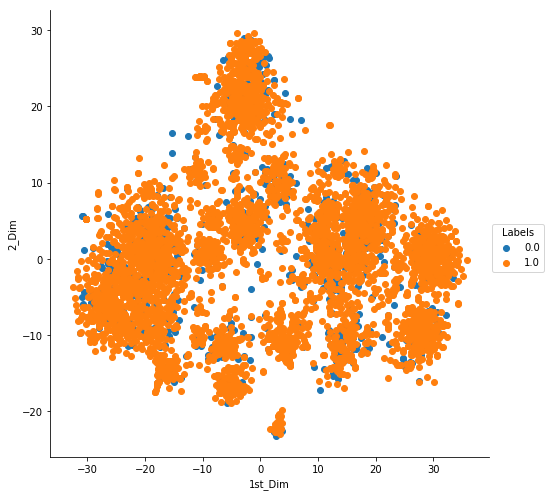

In [325]:
sns.FacetGrid(tsne_df_bow, hue ="Labels", size=7).map(plt.scatter, "1st_Dim","2_Dim").add_legend().fig.suptitle
("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE")
plt.show()

## Summary:

#### 1. Huge number of overlapping is found.
#### 2. Not possible to draw any conclusion from the plot.

## 2.2 TSNE with TFIDF encoding of project_title feature (5000 Data Entries) 

In [314]:
# For TITLE TFIDF
# Combining all the features

X = hstack((categories_one_hot, subcategories_one_hot,school_state_categories_one_hot, project_grade_categories_one_hot
           , teacher_prefix_one_hot, price_standardized, quantity_standardized,previously_posted_standardize, 
            project_title_tfidf))

X.shape

(109248, 5211)

In [315]:
# AS X is scipy.sparse.coo.coo_matrix, we need to convert it into CSR matrix as COO matrix doesnot support slicing.
# CSR - Compressed sparse row matrix.

X = X.tocsr()
X_new = X[0:5000,:]

In [316]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100, random_state = 0)
tsne_tfidf = model.fit_transform(X_new)

In [317]:
tsne_tfidf = np.vstack((tsne_tfidf.T, labels_new)).T
tsne_df_tfidf = pd.DataFrame(tsne_tfidf, columns = ("1_Dim", "2_Dim", "Labels"))

In [318]:
tsne_df_tfidf.shape

(5000, 3)

In [319]:
tsne_df_tfidf.head(5)

1_Dim      2_Dim  Labels
0 -25.875254  31.328411     0.0
1 -26.441296 -46.330540     1.0
2 -21.892513 -42.897079     0.0
3  29.321672  43.428047     1.0
4  40.592762 -11.540601     1.0

In [320]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

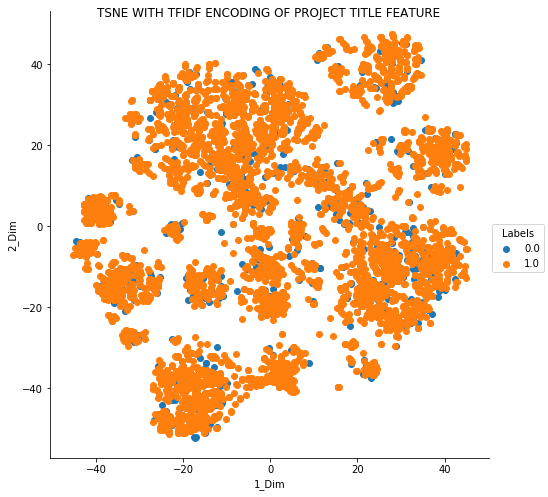

In [326]:
sns.FacetGrid(tsne_df_tfidf, hue = 'Labels', size = 7).map(plt.scatter, "1_Dim","2_Dim").add_legend().fig.suptitle("TSNE WITH TFIDF ENCODING OF PROJECT TITLE FEATURE")
plt.show()

## Summary

#### 1. No cluster is formed between orange and the blue dots i.e between 0 & 1. We can only say that amount of project accepted is more than the rejected project.
#### 2. Nothing can be predicted from the plot using TSNE data using TFIDF encoding

## 2.3 TSNE with AVG W2V encoding of project_title feature (5000 Data Entries)

In [327]:
# For TITLE AVG W2V
# Combining all the features

X = hstack((categories_one_hot, subcategories_one_hot,school_state_categories_one_hot, project_grade_categories_one_hot
           , teacher_prefix_one_hot, price_standardized, quantity_standardized,previously_posted_standardize, 
            avg_w2v_title))

X.shape

(109248, 404)

In [328]:
# Converting to csr matrix
X = X.tocsr()
X_new = X[0:5000,:]

In [329]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100, random_state = 0)
tsne_avg_w2v = model.fit_transform(X_new)

In [331]:
tsne_avg_w2v = np.vstack((tsne_avg_w2v.T, labels_new)).T
tsne_df_avg_w2v = pd.DataFrame(tsne_avg_w2v, columns = ("1st_Dim","2_Dim","Labels"))

In [332]:
tsne_df_avg_w2v.shape

(5000, 3)

In [333]:
tsne_df_avg_w2v.head()

1st_Dim      2_Dim  Labels
0  38.849491 -16.221687     0.0
1 -40.488152 -33.934219     1.0
2 -39.593990 -29.755360     0.0
3  36.689274  31.428202     1.0
4 -19.253521  37.227459     1.0

In [334]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

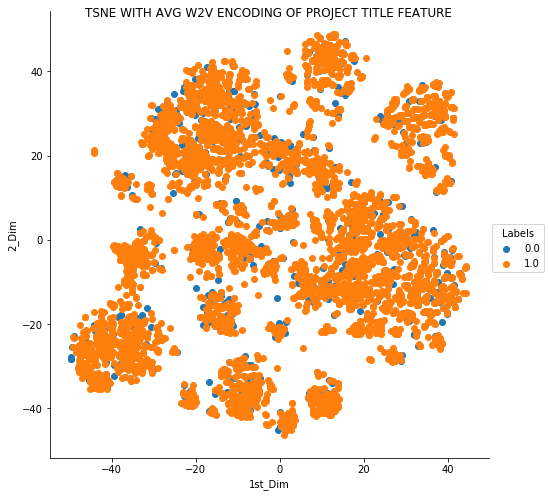

In [337]:
sns.FacetGrid(tsne_df_avg_w2v, hue = "Labels", size = 7).map(plt.scatter, "1st_Dim","2_Dim").add_legend().fig.suptitle("TSNE WITH AVG W2V ENCODING OF PROJECT TITLE FEATURE")
plt.show()

## Summary:

#### Not a single cluster of orange and blue is formed, whether the project is accepted or not. We are not able to predict using the avg w2v.

## 2.4 TSNE with TFIDF weighted W2V encoding of project_title feature (5000 Data Entries)

In [338]:
# For TFIDF weighted W2V 
# Combining all the features

X = hstack((categories_one_hot, subcategories_one_hot,school_state_categories_one_hot, project_grade_categories_one_hot
           , teacher_prefix_one_hot, price_standardized, quantity_standardized,previously_posted_standardize, 
            tfidf_w2v_project_title))

X.shape

(109248, 404)

In [339]:
X = X.tocsc()
X_new = X[0:5000,:]

In [340]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100, random_state=0)
tsne_tfidf_w2v = model.fit_transform(X_new)

In [341]:
tsne_tfidf_w2v = np.vstack((tsne_tfidf_w2v.T, labels_new)).T

# Creating dataframe for plotting
tsne_df_tfidf_w2v = pd.DataFrame(tsne_tfidf_w2v, columns=("1st_Dim", "2nd_Dim","Labels"))

In [342]:
tsne_df_tfidf_w2v.shape

(5000, 3)

In [343]:
tsne_df_tfidf_w2v.head()

1st_Dim    2nd_Dim  Labels
0  15.382308   5.554343     0.0
1  -0.502578 -26.028364     1.0
2  -8.091557 -29.826576     0.0
3 -14.898907  25.012638     1.0
4  -8.618260  16.159550     1.0

In [344]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

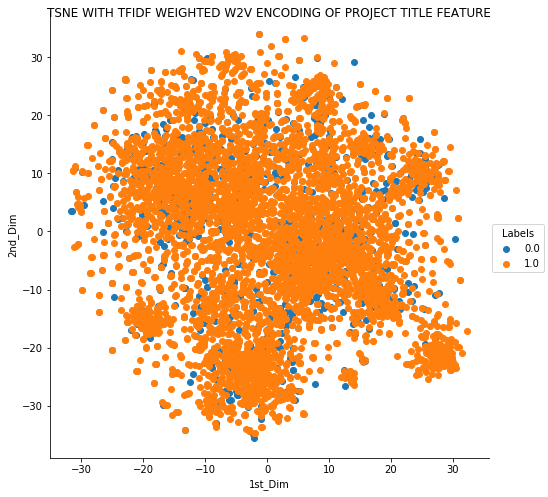

In [345]:
sns.FacetGrid(tsne_df_tfidf_w2v, hue = "Labels",size = 7).map(plt.scatter, "1st_Dim","2nd_Dim").add_legend().fig.suptitle("TSNE WITH TFIDF WEIGHTED W2V ENCODING OF PROJECT TITLE FEATURE")
plt.show()

## Summary:

#### The visualization using tfidf weighted w2v doesnt give any result about the clustering of accepted project and rejected project. Hence this plot is not useful.

## 2.5. TSNE with BOW, TFIDF, AVG W2V, TFIDF Weighted W2V encoding of project tiile features (5000 Data Entries)

In [346]:
# Combining all the features

X = hstack((categories_one_hot, subcategories_one_hot,school_state_categories_one_hot, project_grade_categories_one_hot
           , teacher_prefix_one_hot, price_standardized, quantity_standardized,previously_posted_standardize,
            project_title_text_bow, project_title_tfidf,avg_w2v_title, tfidf_w2v_project_title))

X.shape

(109248, 10918)

In [347]:
# tocsr matrix
X = X.tocsr()
X_new = X[0:5000,:]

In [348]:
X_new = X_new.toarray()
model = TSNE(n_components=2, perplexity=100,random_state=0)
tsne_all = model.fit_transform(X_new)

In [349]:
tsne_all = np.vstack((tsne_all.T, labels_new)).T

# Creating DataFrame
tsne_df_all = pd.DataFrame(tsne_all, columns=("1st_Dim","2nd_Dim","Labels"))

In [350]:
tsne_df_all.shape

(5000, 3)

In [351]:
tsne_df_all.head()

1st_Dim    2nd_Dim  Labels
0   7.983811 -10.688295     0.0
1 -25.115055 -17.901628     1.0
2 -34.381905 -13.468097     0.0
3  23.527449 -20.076914     1.0
4  25.950546  -3.616376     1.0

In [352]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

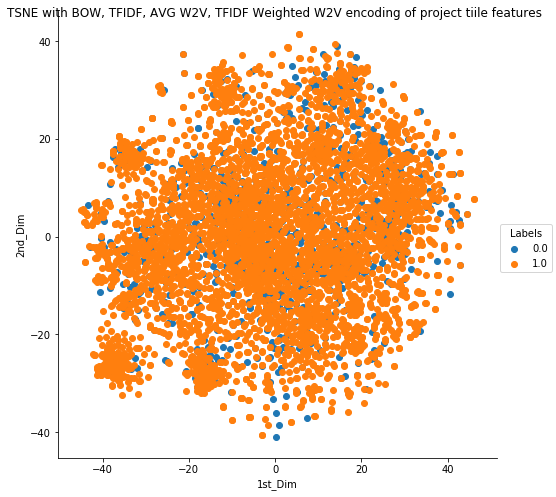

In [353]:
sns.FacetGrid(tsne_df_all, hue="Labels",size=7).map(plt.scatter,"1st_Dim","2nd_Dim").add_legend().fig.suptitle("TSNE with BOW, TFIDF, AVG W2V, TFIDF Weighted W2V encoding of project tiile features ")
plt.show()

## Summary:

#### Combining all the features i.e BOW, TFIDF, AVG W2V, TFIDF Weighted W2V doesnot give us any idea about the acceptance and rejection.

## CONCLUSION

#### 1.Delaware(DE) state has the highest percentage of projects accepted having almost 90% acceptance rate, followed by North Dakota(ND) and Washington(WA) nearly 89% and 88% respectively.
#### 2. Vermont(VT) has the lowest acceptance rate followed by District of Columbia(DC) and Texas(TX) with nearly 80% and 81% respectively.
#### 3. A Total of 15388 number of projects submitted alone by California which is the highest among all the states and the success rate is 85% ie 13205 out of 15388.
#### 4. It can also be noticed that the state with minimum number of projects applied is Vermont(VT) i.e 80, exactly 80% of the projects got approved(64). Only 16 projects failed to get approved.
#### 5. Married woman teachers have applied the most of projects and the acceptance rate is well above 85% followed by non married female teachers whose acceptance rate is 84%.
#### 6. Maximum number of Projects have been approved for the students between the grades PreK & 2 and nearly 85% is the acceptance rate.
#### 7. It can also be noticed that for the higher garde students i.e grades 6-8 & grades 9-12, the number of projects is less as compared to the rest grades.
#### 8. Maximum number of projects propposed is for the category Literacy_Language having the acceptance rate of approx 87% followed by Math_Science with 82% acceptance rate.
#### 9. Those projects which came under the Warmth Care_Hunger has the most acceptance rate of 92% i.e out of 1309 projects submitted 1212 projects got cleared.
#### 10. The Subcategory Literacy has the most number of projects proposed i.e 9486, out of total 8371 got approved making the accepatnce rate to 86%.
#### 11. Likewise the Subcategory Health_wellness has the least number of projects proposed i.e 3583, and out of total 3131 got approved making the acceptance rate to 87%
#### 12. Maximum projects have a title length of 3,4,and 5.
#### 13. Very less number of projects have title more than 10 words.
#### 14.  Approved projects have slightly more words in their project essay as compared to the number of words of rejected projects.
#### 15. The maximun price of any project to enroll should not be more than 10,000 dollars
#### 16. maximum number of project are proposed by New teachers and the acceptance rate is 82%. Approval rate increases for those teachers who have posted more than 15 projects.
#### 17.  Majority of the projects which are proposed doesnot contain any numeric values, and the rate of acceptance is 84%, But we can say that the rate of acceptance for those projects is slightly more than the rejected projects.
#### 18. The average price of each project is 298 dollars with a standard deviation of 367 dollars.
#### 19. On an average a project contains approx 17 similar items and price could be generally paid for these items, Donors can choose any project based on these items.
#### 20. Teachers on an average proposes 11 different projects, well we can say that teachers wants to do something for the wellness of students.
#### 21. Combining all the features i.e BOW, TFIDF, AVG W2V, TFIDF Weighted W2V doesnot give us any idea about the acceptance and rejection.